[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/docs/tutorials/spherical_flow_example.ipynb)
[![Open on Github](https://img.shields.io/badge/github-Open%20on%20Github-black?logo=github)](https://github.com/jfcrenshaw/pzflow/blob/main/docs/tutorials/spherical_flow_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow matplotlib healpy

-------------------
## Modeling data with a compact domain and periodic topology

This example notebook demonstrates using PZFlow to model data on a sphere (specifically the Earth).
This is slightly more complicated, as two of our variables, specifically latitude and longitude, belong to a space with non-Euclidean topology.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import jax.numpy as jnp

from pzflow import Flow
from pzflow.bijectors import Chain, NeuralSplineCoupling, Roll, StandardScaler, ShiftBounds
from pzflow.distributions import Joint, Normal, Uniform
from pzflow.examples import get_city_data

In [2]:
plt.rcParams["figure.facecolor"] = "white"

First let's load the city data included with pzflow.

In [3]:
cities = get_city_data()
cities

,Country,City,Population,Latitude,Longitude
0,Andorra,Andorra la Vella,20430.0,42.500000,1.516667
1,Andorra,Canillo,3292.0,42.566667,1.600000
2,Andorra,Encamp,11224.0,42.533333,1.583333
3,Andorra,La Massana,7211.0,42.550000,1.516667
4,Andorra,Les Escaldes,15854.0,42.500000,1.533333
...,...,...,...,...,...
47961,Zimbabwe,Redcliffe,38231.0,-19.033333,29.783333
47962,Zimbabwe,Rusape,23761.0,-18.533333,32.116667
47963,Zimbabwe,Shurugwi,17107.0,-19.666667,30.000000
47964,Zimbabwe,Victoria Falls,36702.0,-17.933333,25.833333


We can see we have a list of about 48,000 cities, along with their locations and populations.
We will use this to approximately model the population density of the Earth.

Let's convert the angles to radians and calculate the logarithm of the populations.
In addition, let's convert latitude to a zenith angle, and longitude so that its range is $[0,2\pi]$ instead of $[-\pi,+\pi]$.

In [4]:
logpop = np.log10(cities['Population'].to_numpy())
theta = np.radians(90 - cities['Latitude'].to_numpy())
phi = np.radians(180 + cities['Longitude'].to_numpy())

Let's use `healpy` to plot a Mollweide projected histogram of our data.

In [5]:
def mollweide_hist(theta, phi, weights=None, nside=64, **kwargs):
    """Make a healpix histogram with a Mollweide projection.
    
    theta : array
        Array of zenith angles.
    phi : array
        Array of azimuth angles.
    weights : array
        Weight of each point.
    nside : int, default=64
        HEALPix nside of the target map
    """
    
    if weights is not None:
        theta = np.repeat(theta, np.rint(weights).astype(int))
        phi = np.repeat(phi, np.rint(weights).astype(int))
    
    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi - np.pi)
    idx, counts = np.unique(indices, return_counts=True)
    npix = hp.nside2npix(nside)
    
    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    # plot histogram
    hp.mollview(np.log10(hpx_map+1), **kwargs)

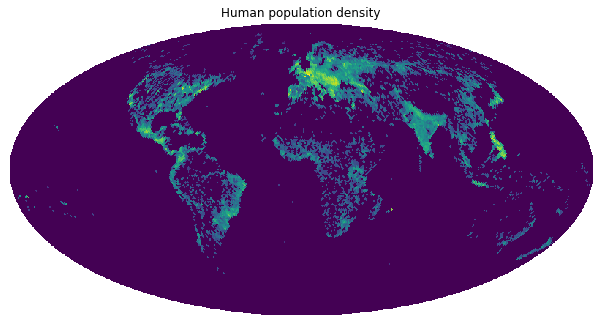

In [6]:
mollweide_hist(theta, phi, 
               weights=logpop, 
               nside=64, 
               title="Human population density", 
               flip="geo", 
               cbar=False)

Now we want to model this data with a normalizing flow. As we mentioned above, the latitude and longitude variables must be treated with special care, as the live in $S^2$ instead of $\mathbb{R}^2$.
However, the sphere $S^2$ can be decomposed into an interval and a circle. In other words, the map $(\theta, \phi) \to (\cos(\theta), \phi)$ maps the sphere to a cylinder, $S^2 \to [-1,1] \times S^1$.

What this means is we can model $\cos(\theta)$ in the usual way, as long as we map it to a latent distribution with compact support, e.g. the uniform distribution $\mathcal{U}(-5, 5)$.

However, $\phi$ still lives on the circle. Fear not, we can still model $\phi$ with our usual bijectors, as long as we enforce the following boundary conditions:
$$ f(0) = 0, \quad f(2\pi) = 2\pi, \quad \nabla\! f(0)= \nabla\! f(2\pi), \quad \nabla\! f(\phi) > 0.$$
We will see that these conditions are easy to impose with our Neural Spline Coupling. 

First, let's create a DataFrame with our transformed data:

In [7]:
data = pd.DataFrame(np.array([phi, np.cos(theta), logpop]).T, columns=("phi", "cos(theta)", "logpop"))

Now let's create our bijector. It'll be very similar to what we've done before, with small changes:

1. First, when we use `ShiftBounds`, rather than setting `B=4` to avoid the boundary, we will set `B=5`, because we don't want the flow to be able to sample beyond the limits of our angles.
2. Instead of using `RollingSplineCoupling`, we will manually use `NeuralSplineCoupling` so that we can set `periodic=True` on the splines that transform $\phi$. 
3. We will set `transformed_dim=1` to make sure that each spline only transforms one of the dimensions at a time.
4. I will increase the resolution of the splines (by increasing `K`), and increase the depth of the neural networks that parameterize the splines (by increasing `hidden_layers`).

Since the data columns in `data` are `("phi", "cos(theta)", "logpop")`, this means that the first `NeuralSplineCoupling` transforms `logpop`, and the second (after the `Roll`) transforms $\cos(\theta)$. 
Thus after the second `Roll`, $\phi$ is now in the last column.

We can now apply a `NeuralSplineCoupling` with `periodic=True`.
This is all we have to do to enforce the periodic constraints we listed above!

After one more `Roll`, all of the columns are back in the same order they started in.
This is important, as it ensures that each dimension lines up the correct dimension of the latent space that we set up above.

In [8]:
mins = jnp.array(data.min(axis=0))
maxs = jnp.array(data.max(axis=0))

bijector = Chain(
    ShiftBounds(mins, maxs, 5),
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1),
    Roll(),
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1),
    Roll(),
    NeuralSplineCoupling(K=128, hidden_layers=4, transformed_dim=1, periodic=True),
    Roll(),
)

flow = Flow(data.columns, bijector)

Now we can train our flow:

In [9]:
losses = flow.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
(0) 4.3741
(1) 2.7319
(11) 1.0787
(21) 0.7544
(31) 0.5492
(41) 0.5004
(51) 0.3901
(61) 0.4068
(71) 0.2925
(81) 0.2543
(91) 0.2410
(101) 0.1949
(111) 0.1393
(121) 0.1146
(131) 0.1445
(141) 0.0759
(151) 0.0442
(161) 0.0292
(171) 0.0186
(181) 0.0108
(191) -0.0175
(200) 0.0124


Let's plot the training losses to make sure everything looks okay.

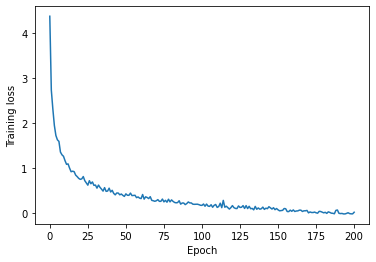

In [10]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Now let's draw samples from the trained flow, and plot them together with the truth data.

In [11]:
# sample from the trained flow
samples = flow.sample(data.shape[0], seed=0)

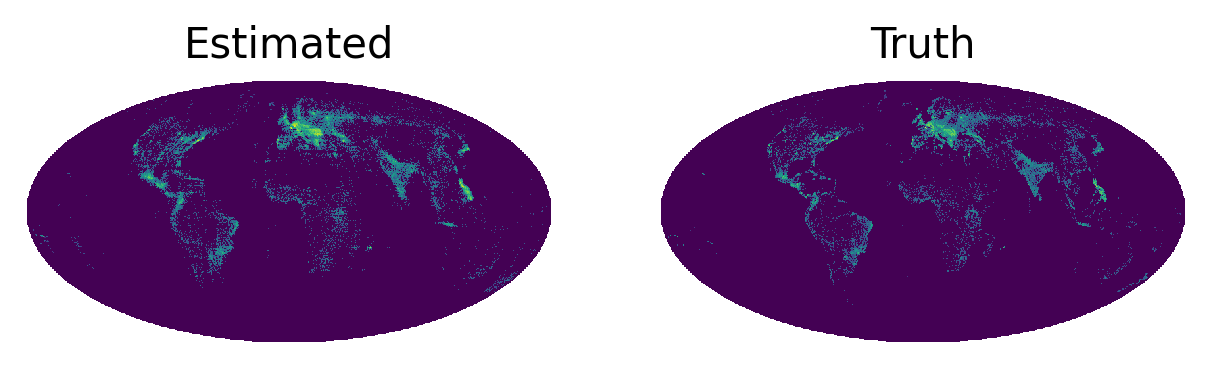

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,4), dpi=250)

nside = 128
flip = "geo"
cbar = False

# trained flow
plt.axes(ax1)
mollweide_hist(
    np.arccos(samples["cos(theta)"].to_numpy()),
    samples["phi"].to_numpy(),
    weights=samples["logpop"],
    title="Estimated",
    nside=nside,  
    flip=flip, 
    cbar=cbar,
    hold=True,
)

# truth
plt.axes(ax2)
mollweide_hist(
    theta,
    phi,
    weights=logpop,
    title="Truth",
    nside=nside,  
    flip=flip, 
    cbar=cbar,
    hold=True,
)

Pretty good! You could get even better resolution by training for longer and doing some hyperparameter tuning.